# Introduction

This part of the project try with machine learning technics to predict the flow and the entry load (filter clogging level) in function of the current consumed by the pump.<br>
In the previous notbook we have seen the current measured contains noise that need to be filtered, the frequence selected to filter the current is also explained on this notebook: [Current filtering](./Capstone Milestone report.ipynb) <br>
The following code will load the dataset with the measure obtained with the data aquisition module : [Aquisition module](../Data Aquisition/LabjackTestPython.ipynb)<br>
Current measured and transformed to a numeric 12 bits value is transformed in amper. The flow pulse number are converted in liter/ hour and the entry load is transformed in a value varying between 0 and 100.

In [180]:
import pandas as pd
import numpy as np

def load_acquisition_data(filelocation):
    format = '%Y-%m-%d %H:%M:%S,%f'
    df =pd.read_csv(filelocation, sep=';',parse_dates=True);
    times = pd.to_datetime(df.DateTime , format=format)
    df.set_index(times, inplace=True)
    df['ValveOpening'] = df['EntryLoad'] - df['EntryLoad'].shift(-1) <0
    return df

pumpdata = load_acquisition_data('..\data\PumpMeasuresFormated.csv')
pumpdata["Flow"]=(pumpdata["Flow"]/97)*360
pumpdata["PumpCurrent"] = ((pumpdata["PumpCurrent"]/4095)*2.44 +3.85)/(11.8*0.5)
pumpdata["EntryLoad"]= pumpdata["EntryLoad"]/255*100

C:\Anaconda343\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


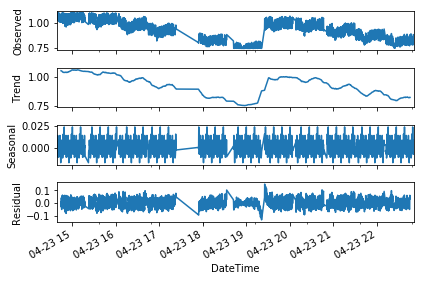

In [181]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm 

decompfreq = 52
res = sm.tsa.seasonal_decompose(pumpdata.PumpCurrent.interpolate(),freq=decompfreq, model='additive')
res.plot()
pumpdata["CurrentFiltered"] = res.trend
#Remove row containing NaN value
#The current decomposition process with the stats model library produce some NaN values.
#We remove these NaN from the dataset
pumpdataCleaned= pumpdata.dropna()

In [182]:
pumpdataCleaned.head()

,Id,Cycle,DateTime,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity,ValveOpening,CurrentFiltered
DateTime,,,,,,,,,,
2017-04-23 14:44:18.277,26,1,"2017-04-23 14:44:18,277",371.134021,49.019608,100,1.054589,10,False,1.050433
2017-04-23 14:44:31.306,27,1,"2017-04-23 14:44:31,306",367.422680,47.058824,100,1.015101,10,False,1.050071
2017-04-23 14:44:44.337,28,1,"2017-04-23 14:44:44,337",371.134021,45.098039,100,1.084785,10,False,1.049464
2017-04-23 14:44:57.367,29,1,"2017-04-23 14:44:57,367",363.711340,43.137255,100,1.027119,10,False,1.048858
2017-04-23 14:45:10.397,30,1,"2017-04-23 14:45:10,397",356.288660,41.176471,100,1.005608,10,False,1.048149


In [183]:
pumpdataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1928 entries, 2017-04-23 14:44:18.277000 to 2017-04-23 22:45:35.554000
Data columns (total 10 columns):
Id                 1928 non-null int64
Cycle              1928 non-null int64
DateTime           1928 non-null object
Flow               1928 non-null float64
EntryLoad          1928 non-null float64
OutputLoad         1928 non-null int64
PumpCurrent        1928 non-null float64
PumpVelocity       1928 non-null int64
ValveOpening       1928 non-null bool
CurrentFiltered    1928 non-null float64
dtypes: bool(1), float64(4), int64(4), object(1)
memory usage: 152.5+ KB


# Matrix correlation

This analysis is already presented in the data visualisation notebook. Because the dataset is small the compute of the matrix correlation is fast.<br>

In [184]:
corrMatrix = pumpdataCleaned.corr()
corrMatrix["Flow"].sort_values(ascending=False)

Flow               1.000000
CurrentFiltered    0.522893
PumpCurrent        0.505688
EntryLoad          0.493927
OutputLoad         0.406369
PumpVelocity       0.389661
ValveOpening      -0.092312
Id                -0.574054
Cycle             -0.591575
Name: Flow, dtype: float64

We can see the flow variation could be expained by :
- The current consumed by the pump 0.52
- The entry load 0.49
- The Output load 0.40
- The pump velocity 0.38
- The cycle number -0.59 (The flow variation is inverted compared to the cycle number because cycle 1 correspond to a high value of the velocity and 100% for the output load and each cycle decrease these parameter.<br>

We can say it seem possible to build a function taking:
- The current consumed
- The the output load
- The pump velocity selection

To predict the flow.

In [185]:
corrMatrix = pumpdataCleaned.corr()
corrMatrix["CurrentFiltered"].sort_values(ascending=False)

CurrentFiltered    1.000000
PumpVelocity       0.918880
PumpCurrent        0.909811
Flow               0.522893
EntryLoad          0.097973
OutputLoad         0.080320
ValveOpening       0.022181
Id                -0.543076
Cycle             -0.548452
Name: CurrentFiltered, dtype: float64

The variation of the current is explained by the velocity : 0.92 of the pump and the flow : 0.52<br>
We will use the important features in correlation with the flow and the entry load to predict these value in the following part of this document.

# PCA analysis
We create a new dataset keeping only the most important parameters of the model:
- Current consumed by the pump
- Pump Velocity selection on the control unit
- Output load controled by the manual valve
- Entry load controled by the entry valve

We will try with the help of the PCA to construct a simplified model (2 dimensions) and represent it in a graphic

In [186]:
pcaSet = pumpdataCleaned.copy()
pcaSet = pcaSet.drop("PumpCurrent",axis=1)
#pcaSet = pcaSet.drop("EntryLoad",axis=1)
#pcaSet = pcaSet.drop("CurrentFiltered",axis=1)
#pcaSet = pcaSet.drop("Flow",axis=1)
pcaSet = pcaSet.drop("Cycle",axis=1)
pcaSet = pcaSet.drop("Id",axis=1)
pcaSet = pcaSet.drop("DateTime",axis=1)
pcaSet = pcaSet.drop("ValveOpening",axis=1)

In [187]:
pcaSet.head()

,Flow,EntryLoad,OutputLoad,PumpVelocity,CurrentFiltered
DateTime,,,,,
2017-04-23 14:44:18.277,371.134021,49.019608,100,10,1.050433
2017-04-23 14:44:31.306,367.422680,47.058824,100,10,1.050071
2017-04-23 14:44:44.337,371.134021,45.098039,100,10,1.049464
2017-04-23 14:44:57.367,363.711340,43.137255,100,10,1.048858
2017-04-23 14:45:10.397,356.288660,41.176471,100,10,1.048149


For the graphic we recreate the cycle using a composite information, the product of the velocity by the output load. For each cycle the parameter (velocity, output load) change.

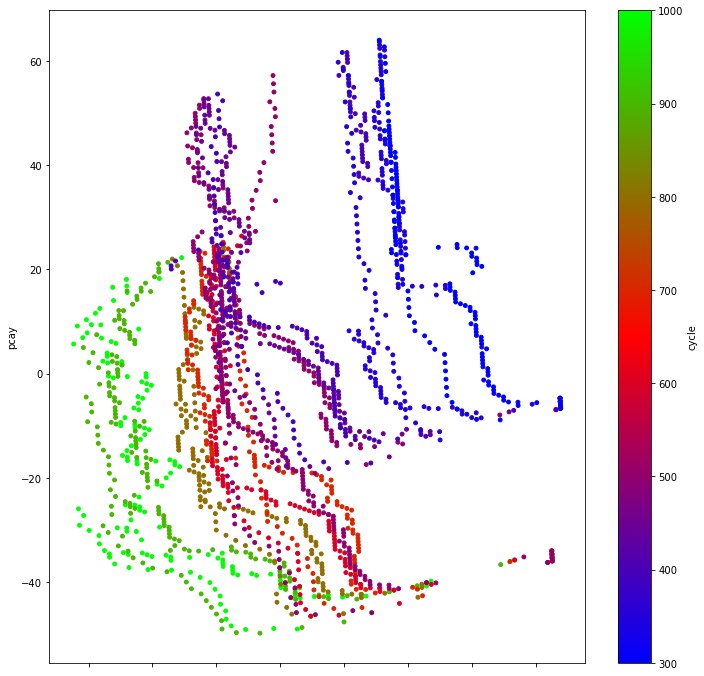

In [188]:
x_cols = pcaSet.as_matrix()
from sklearn.decomposition import PCA

#Calculate the PCA for two components
pca = PCA(n_components=2)
x_converted=pca.fit_transform(x_cols)
#Create a dataframe with the x,y coordinate of the PCA
cycleinfo=pcaSet["OutputLoad"]*pcaSet["PumpVelocity"]
d = {'pcax':x_converted[:,0], 'pcay':x_converted[:,1],'cycle':cycleinfo}
df = pd.DataFrame(d, index=pcaSet.index)

df.plot('pcax', 'pcay', c='cycle', kind='scatter',cmap='brg',s=15, figsize=(12,12))

# PCA analysis conclusion
We can observe after model complexity reduction with PCA, we can't obtain only one continuous model that represent the relation between the current consumed by the pump and the entry load or the flow delivered.<br> The graphic shows two groups of curve and each group corresponds to the output load selection.<br> The lowest curve represents the output load at 100% and the higher to the 50%. The intens green = 1000 correspond to the product velocity with output load (10x1000) and the intens blue to (6x50).<br> For each group we can see a similar curve to what we have seen when we observed the relation between the flow and the current.<br><br>
In the next step of this study we will do an analysis using a <b>Tree regressor</b> to predict the flow and the entry load.<br> Because the model is non linear or linear by interval , decision tree is a good solution to address this problem. For this analysis some function are developped to simplify the analysis and will be reused for the two analysis.


# Modeling

These functions are tools used to extract the feature set and the label set from the training and test data.<br>
Training set is obtained using the method <b>train_test_split</b> in sklean .<bR> 20% of the measure are used for the test and the random_state parameter allow the experiment to be repeatable.

In [189]:
from sklearn.model_selection import train_test_split

def split_train_test(data) :
    trainSet, testSet = train_test_split(data, test_size = 0.2, random_state=2)
    return trainSet, testSet

def get_feature(data):
    featureSet = data.copy();
    featureSet = featureSet.drop("EntryLoad",axis=1)
    featureSet = featureSet.drop("Flow",axis=1) 
        
    featureSet = featureSet.drop("PumpCurrent",axis=1)
    featureSet = featureSet.drop("Cycle",axis=1)
    featureSet = featureSet.drop("Id",axis=1)
    featureSet = featureSet.drop("DateTime",axis=1)
    featureSet = featureSet.drop("ValveOpening",axis=1)
    return featureSet

def get_featurePlusCycle(data):
    featureSet = data.copy();
    featureSet = featureSet.drop("EntryLoad",axis=1)
    featureSet = featureSet.drop("Flow",axis=1)
        
    featureSet = featureSet.drop("PumpCurrent",axis=1)
    featureSet = featureSet.drop("Id",axis=1)
    featureSet = featureSet.drop("DateTime",axis=1)
    featureSet = featureSet.drop("ValveOpening",axis=1)
    return featureSet

def get_label(data,label="Flow"):
    labelset = data[label].copy()
    return labelset

This fuction generates a visual representation of the decision tree generated. This function could be modified to provide the code that will used by the controller piloting the greenhouse to predict the flow or the entry load in function of the different parameter.

In [190]:
from sklearn.tree import _tree

def print_tree(t, root=0, depth=1):
    if depth == 1:
        print('def predict(X_i):')
    indent = '    '*depth
    print (indent + '# node %s: impurity = %.2f' % (str(root), t.impurity[root]))
    left_child = t.children_left[root]
    right_child = t.children_right[root]
     
    if left_child == _tree.TREE_LEAF:
        print (indent + 'return %s # (node %d)' % (str(t.value[root]), root))
    else:
        print (indent + 'if X_i[%d] < %.2f: # (node %d)' % (t.feature[root], t.threshold[root], root))
        print_tree(t, root=left_child, depth=depth+1)
         
        print (indent + 'else:')
        print_tree(t,root=right_child, depth=depth+1)

This function is used to build the best model to predict a given label (entry load or the flow). This function is based on the function <b>GridSearchCV</b> provided by sklearn to explore the different combinaison for the hyper parameter. The model is controled by two parameters :
- The depth of the tree
- The minimum sample a leaf must contain to be considered as a leaf.

The learning set is decomposed in 'n' KFOLD to do a cross validation and a score function is evaluated for each combinaison of hyper parameter. In this case for the decision tree regressor the scoring use the R^2.

After testing the different combinaison of parameter the system keep the best configuration for the hyper parameter.

The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ^ 2).sum() and v is the residual sum of squares ((y_true - y_true.mean()) ^ 2).sum().<br> Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0<br><br>
We will use 20 different values for the depth and 20 different values for the nbr of sample in the leaf.<br> 400 combinaisons per KFOLD are tested. With 10 KFOLD, 4000 tests will be done and the best combinaison of the parameter producing the best score will be kept.<br>
For the best model obtained the function predicts the value for the test set.

In [205]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def fitandPredictCV(labelName,ncv=5):
    testfeatures = get_feature(testSet)
    param_grid = [
        {'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
         'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
    ]
    dt_reg = DecisionTreeRegressor(random_state=2)    
    grid_search =GridSearchCV(dt_reg,param_grid,cv=ncv)
    grid_search.fit(trainfeatures,trainlabels)
    print("KFold number    :", ncv)
    print("Best Params     :" ,grid_search.best_params_)
    print("Best Score R^2  :" ,grid_search.best_score_)
    
    predictions= grid_search.best_estimator_.predict(testfeatures)
    scoreTestSet=grid_search.best_estimator_.score(testfeatures,get_label(testSet))
    print("Score test set R^2  :" ,scoreTestSet)
    return predictions, grid_search.best_estimator_

This function will be applied to the test Set to generate a graphics representing :
- The entry load in function of the current consumed by the pump (for label = EntryLoad)
- The flow in function of the current consumed by the pump (for label = Flow)
<br>

This graphic includes the values corresponding to the prediction (marker = diamond)

In [206]:
def plotLabelversusPrediction(dataset,label,prediction):
    displayds = get_featurePlusCycle(dataset)
    displayds[label]= get_label(dataset,label)
    displayds["prediction"]=prediction
    plt.figure(figsize=(15,15))
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    for cycle in range(1,12):
        subset = displayds[displayds.Cycle==cycle].dropna()
        cyclename = label+ ':' + str(cycle)
        if label=="EntryLoad":
            plt.scatter(subset.CurrentFiltered, subset.EntryLoad, s=10, c=colors[cycle-1], label=cyclename)
        else:
            plt.scatter(subset.CurrentFiltered, subset.Flow, s=10, c=colors[cycle-1], label=cyclename)            
        cyclename = 'Prediction: ' + str(cycle)
        plt.scatter(subset.CurrentFiltered, subset.prediction, s=10, marker='D', c=colors[cycle-1], label=cyclename)
    plt.legend()

# Predict the flow in function of the current consumed by the pump

We will keep only the features and the label we will use for the model

In [207]:
trainSet, testSet = split_train_test(pumpdataCleaned)
trainfeatures = get_feature(trainSet)
trainlabels = get_label(trainSet,"Flow")

In [208]:
trainfeatures.info()
trainfeatures.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542 entries, 2017-04-23 16:57:27.947000 to 2017-04-23 19:54:56.014000
Data columns (total 3 columns):
OutputLoad         1542 non-null int64
PumpVelocity       1542 non-null int64
CurrentFiltered    1542 non-null float64
dtypes: float64(1), int64(2)
memory usage: 48.2 KB


,OutputLoad,PumpVelocity,CurrentFiltered
DateTime,,,
2017-04-23 16:57:27.947,100,7,0.905357
2017-04-23 20:34:05.840,50,9,0.988369
2017-04-23 18:22:17.162,100,6,0.822197
2017-04-23 20:03:11.164,50,10,0.991135
2017-04-23 21:40:07.772,50,7,0.851675


In [209]:
trainlabels.head()

DateTime
2017-04-23 16:57:27.947    137.319588
2017-04-23 20:34:05.840    252.371134
2017-04-23 18:22:17.162    256.082474
2017-04-23 20:03:11.164    274.639175
2017-04-23 21:40:07.772    126.185567
Name: Flow, dtype: float64

In [210]:
predictions,bestmodel= fitandPredictCV("Flow",10)

KFold number    : 10
Best Params     : {'max_depth': 11, 'min_samples_leaf': 15}
Best Score R^2  : 0.687107639888
Score test set R^2  : 0.744370564193


<b>The best model obtained is for a R^2 score equals to 0.687. We can say the prediction on the training set is relatively good and the tree will have a depth = 11 and the minimum samples by leaf = 15.<br>
The score obtained on the test set : 0.74 is better than the score on the test, the model doesn't overfit.</b>

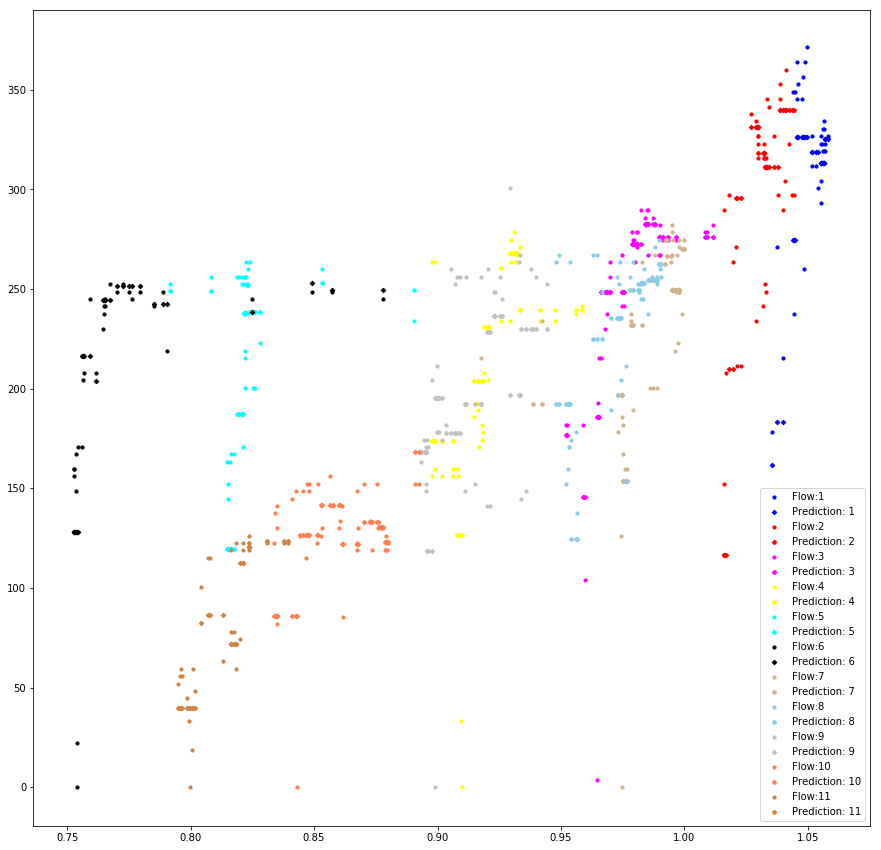

In [211]:
plotLabelversusPrediction(testSet,"Flow",predictions)

This function draw the decision tree corresponding to the best model described above.

In [212]:
print_tree(bestmodel.tree_)

def predict(X_i):
    # node 0: impurity = 6336.00
    if X_i[2] < 0.98: # (node 0)
        # node 1: impurity = 4895.52
        if X_i[0] < 75.00: # (node 1)
            # node 2: impurity = 4502.38
            if X_i[2] < 0.90: # (node 2)
                # node 3: impurity = 1603.50
                if X_i[2] < 0.82: # (node 3)
                    # node 4: impurity = 778.69
                    if X_i[2] < 0.80: # (node 4)
                        # node 5: impurity = 532.76
                        return [[ 39.73317162]] # (node 5)
                    else:
                        # node 6: impurity = 438.83
                        if X_i[2] < 0.81: # (node 6)
                            # node 7: impurity = 490.88
                            if X_i[2] < 0.81: # (node 7)
                                # node 8: impurity = 244.01
                                return [[ 82.1443299]] # (node 8)
                            else:
                                # node 9: impurity = 688.

# Predict the entry load (filter clogging) in function of the current consumed by the pump

We will keep only the features and the label we will use for the model

In [213]:
trainSet, testSet = split_train_test(pumpdataCleaned)
trainfeatures = get_feature(trainSet)
trainlabels = get_label(trainSet,"EntryLoad")

In [214]:
trainfeatures.info()
trainfeatures.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542 entries, 2017-04-23 16:57:27.947000 to 2017-04-23 19:54:56.014000
Data columns (total 3 columns):
OutputLoad         1542 non-null int64
PumpVelocity       1542 non-null int64
CurrentFiltered    1542 non-null float64
dtypes: float64(1), int64(2)
memory usage: 48.2 KB


,OutputLoad,PumpVelocity,CurrentFiltered
DateTime,,,
2017-04-23 16:57:27.947,100,7,0.905357
2017-04-23 20:34:05.840,50,9,0.988369
2017-04-23 18:22:17.162,100,6,0.822197
2017-04-23 20:03:11.164,50,10,0.991135
2017-04-23 21:40:07.772,50,7,0.851675


In [215]:
trainlabels.head()

DateTime
2017-04-23 16:57:27.947     7.058824
2017-04-23 20:34:05.840    53.333333
2017-04-23 18:22:17.162    61.960784
2017-04-23 20:03:11.164    97.254902
2017-04-23 21:40:07.772    17.647059
Name: EntryLoad, dtype: float64

In [216]:
predictions,bestmodel= fitandPredictCV("EntryLoad",10)

KFold number    : 10
Best Params     : {'max_depth': 13, 'min_samples_leaf': 9}
Best Score R^2  : 0.43364086486
Score test set R^2  : -4.29811040024


<b>The best model obtained is for a R^2 score equals to 0.433. We can say the prediction is bad for the training set and the tree will have a depth = 13 and the minimum samples by leaf = 9.<br>
The score on the test set is negative! We can say the model is very bad to predict the entry load.</b>

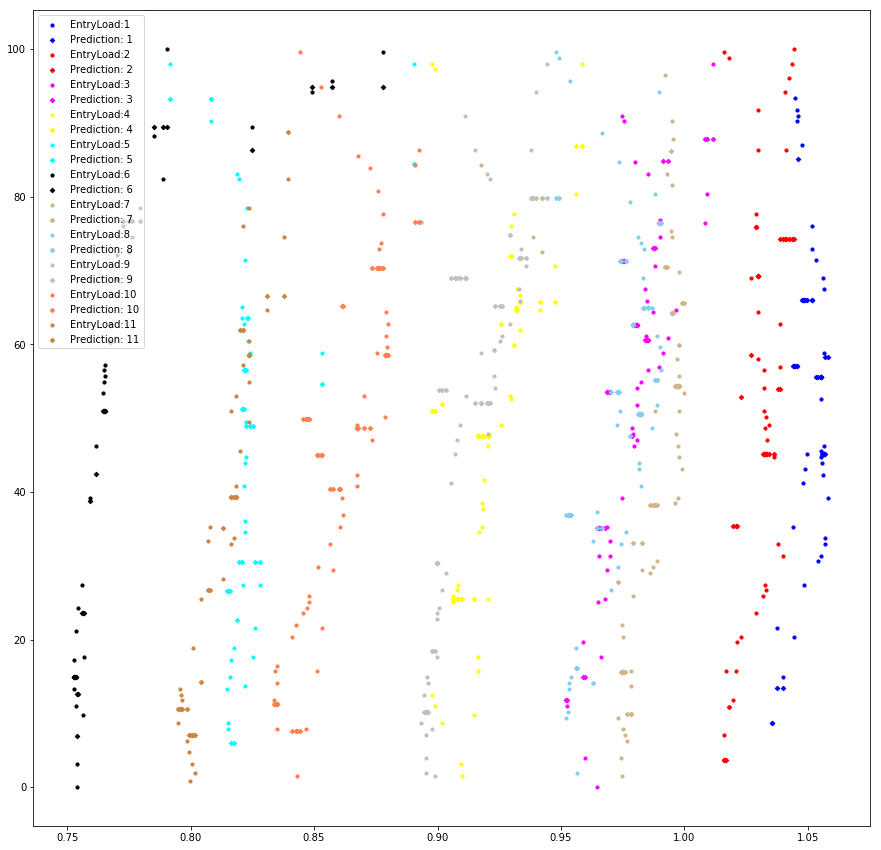

In [203]:
plotLabelversusPrediction(testSet,"EntryLoad",predictions)

In [217]:
print_tree(bestmodel.tree_)

def predict(X_i):
    # node 0: impurity = 848.79
    if X_i[2] < 0.76: # (node 0)
        # node 1: impurity = 86.86
        if X_i[2] < 0.76: # (node 1)
            # node 2: impurity = 66.42
            if X_i[2] < 0.75: # (node 2)
                # node 3: impurity = 28.24
                return [[ 14.96732026]] # (node 3)
            else:
                # node 4: impurity = 80.37
                if X_i[2] < 0.75: # (node 4)
                    # node 5: impurity = 39.84
                    return [[ 6.97167756]] # (node 5)
                else:
                    # node 6: impurity = 99.17
                    return [[ 12.62032086]] # (node 6)
        else:
            # node 7: impurity = 40.17
            return [[ 23.58974359]] # (node 7)
    else:
        # node 8: impurity = 835.98
        if X_i[1] < 5.50: # (node 8)
            # node 9: impurity = 406.38
            if X_i[2] < 0.77: # (node 9)
                # node 10: impurity = 95.95
                if X_i[2] < 0.76

# General conclusion

The objective of the project was to try to predict the entry load of the pump (image of the fitter clogging) with a measure of the current consumed by the pump and the other parameters:
- Velocity of the pump selected
- Output load (represented by the water distribution circuit)
<br>

After cleaning the current containing noise we have observed how this parameter are correlated.
<br>
We see the flow could be explained by this feature in the follwing order :
- The current consumed by the pump 0.52
- The entry load 0.49
- The Output load 0.40
- The pump velocity 0.38
<br>

The current consumed could be explained by this features in the following order :
- The pump velocity 0.92
- The flow  0.52
<br>

The entry load and the current consummed by the pump have a bad correlation
<br><br>
The model shows we can predict the flow with a relatively good score R^2 = 0.74 using :
- The current
- The pump velocity selected
- The output load
<br>

The model to predict the entry load in function of the current provides a negative score R^2 = -4.29. We can't use this model to predict the entry load in function of the current.


<b>We can say it will be possible to predict the flow in function of the measure of the current and for a given velocity of the pump and estimated constant output load.</b><br> The decision tree generated to predict the flow could be transformed in code for the language used to develop the control system of the greenhouse.<br>
The velocity of the pump and the output load will be parameters of the program used to measure the flow. In case of maintenance of the greenhouse when the pump is stopped, the program that compute the flow must be disabled to not generate alert.<br>
We can consider a limit low of the flow for a given condition (pump velocity and output load) will be the trigger of an alert.<br> If the flow remains low for a given period of time we an alert could be generated. This period will be another parameter of the program that watch the flow drop.